# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 1.10.2021

Мягкий дедлайн: 17.10.2021 23:59 МСК

Жесткий дедлайн: 31.10.2021 23:59 МСК (1 неделя -- минус балл)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Загрузите решение в свой репозиторий на github и поделитесь [ссылкой на решение в форме](https://forms.gle/ZzCaqRj6bmfpSpyL7). Не забудьте дать доступ к Вашему репозиторию, что у преподавателей была возмоожность проверить работу.

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [21]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from scipy.spatial.distance import pdist, squareform
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from itertools import product
import lightgbm as lgbm
import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [22]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [23]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, sample_size=0.5, classifier='logreg', hyper_params={}):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.

        sample_size, float: sample percentage to draw samples for computing sigma.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        hyper_params, dict: classifier's hyperparams.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.sample_size = sample_size
        self.classifier = classifier
        self.hyper_params = hyper_params
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
            
        self.new_dim = X.shape[1]
        X_sample = X[np.random.randint(X.shape[0], size=int(np.ceil(X.shape[0] * self.sample_size))), :]
        self.sigma_sq = np.median(pdist(X_sample, metric='sqeuclidean'))
        
#         self.w = np.random.normal(loc=0, scale=1/np.sqrt(self.sigma), size=self.n_features)
        self.w = np.zeros(shape=(self.n_features, self.new_dim))

        for n in range(self.n_features):
#             self.w[n, :] = multivariate_normal.rvs(cov=np.eye(self.new_dim) * (1/sigma_sq))
#             Генерируем вес независимо для каждой фичи
            self.w[n, :] = np.random.normal(loc=0, scale=1/np.sqrt(self.sigma_sq), size=self.new_dim)
        
        self.b = np.random.uniform(low=-np.pi, high=np.pi, size=self.n_features)
        fi = np.cos(self.w @ X.T + self.b.reshape(self.n_features, -1)).T
        
        if self.classifier=='logreg':
            self.clf = LogisticRegression(**self.hyper_params)
        elif self.classifier=='svm':
            self.clf = LinearSVC(**self.hyper_params)
        self.clf.fit(fi, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        
        if self.use_PCA:
            X = self.pca.transform(X)
        fi_pred = np.cos((self.w @ X.T) + self.b.reshape(self.n_features, -1)).T
        pred = self.clf.predict_proba(fi_pred)
        
        return pred
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        
        if self.use_PCA:
            X = self.pca.transform(X)
        fi_pred = np.cos((self.w @ X.T) + self.b.reshape(self.n_features, -1)).T
        pred = self.clf.predict(fi_pred)
        
        return pred

In [ ]:
# Не сходится с маленьким числом max_iter, а с увеличением числа итераций - долго обучается.
print('Тест на данных Fashion MNIST')
rff = RFFPipeline(hyper_params={'max_iter': 500})
rff.fit(x_train, y_train)
rff_pred_test = rff.predict(x_test)
ac = accuracy_score(y_test, rff_pred_test)
assert ac >= 0.84, 'Доля верных ответов ниже 0.84 :('
print('Доля верных ответов на тесте: {}'.format(ac))

Тест на данных Fashion MNIST


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Доля верных ответов на тесте: 0.8787


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [ ]:
# Размерность в новом пространстве для PCA по дефолту 50 (вынесем параметр для использования в градиентном бустинге)
new_dim=50

In [ ]:
models = {
    'Linear SVM': LinearSVC(max_iter=2000, random_state=100),
    'Kernel SVM': SVC(kernel='rbf', random_state=100),
    'RFF': RFFPipeline(new_dim=new_dim, use_PCA=True, classifier='logreg', hyper_params={'max_iter': 2000}),
}

accuracy = {}
times = {}

# Возьмем половину выборки для обучения - все алгоритмы обучаются слишком долго
mask = np.random.randint(x_train.shape[0], size=int(np.ceil(x_train.shape[0] * 0.5)))
x_train_ = x_train[mask, :]
y_train_ = y_train[mask]

for name, model in models.items():
    print(name)
    clf = model
    
    start = time.time()
    clf.fit(x_train_, y_train_)
    # clf.fit(x_train, y_train)

    end = time.time()
    pred_test = clf.predict(x_test)
    
    accuracy[name] = accuracy_score(y_test, pred_test)
    times[name] = end - start

Linear SVM


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Kernel SVM
RFF


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Для градиентного бустинга подбираем гиперпараметры.
pca = PCA(n_components=new_dim)
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)

hp_grid = {
    'max_depth': np.arange(2, 10),
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': np.linspace(0.01, 10, 100)
}

gb = lgbm.LGBMClassifier(objective='multiclass')
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
# start = time.time()
rsearch = RandomizedSearchCV(gb, hp_grid, cv=skf, random_state=100)
rsearch.fit(X_train, y_train)
best_params = rsearch.best_params_
best_params['objective'] = 'multiclass'

gb_clf = lgbm.LGBMClassifier(**best_params)
start = time.time()
gb_clf.fit(X_train, y_train)
end = time.time()
gb_pred_test = gb_clf.predict(X_test)

accuracy['LGBM with PCA'] = accuracy_score(y_test, gb_pred_test)
times['LGBM with PCA'] = end - start

In [ ]:
scores = pd.DataFrame.from_dict(accuracy, orient='index', columns=['Accuracy'])
time_ = pd.DataFrame.from_dict(times, orient='index', columns=['Time'])
results = scores.join(time_).T

In [ ]:
results

,Linear SVM,Kernel SVM,RFF,LGBM with PCA
Accuracy,0.733500,0.870600,0.868700,0.876700
Time,261.858239,166.233782,419.237202,99.794426


Самое высокое качество показывает градиентный бустинг, самое низкое - линейный SVM, что логично, т.к. он распознает только линейные зависимости в данных. Сопоставимым, достаточно высоким качеством с лучшим алгоритмом обладают ядровой SVM и подход со случайными признаками, т.к. данные алгоритмы также улавливают нелинейности с помощью преобразования исходных признаков в нелинейные и перехода таким образом в спрямляющее пространство, где уже можно разделить данные с помощью линейного алгоритма. Также следует отметить, что реализации RFFPipeline и ядровой SVM из sklearn обладают схожим качеством (т.к. в RFFPipeline по сути и приближаем ядро с помощью случайных признаков Фурье). По времени наилучшая реализация у алгоритма LGBM (без учета перебора гиперпараметров), а медленнее всего работает данная реализация подхода со случайными признаками Фурье (RFFPipeline). С учетом перебора ГП градиентый бустинг работал бы дольше.

Таким образом, алгоритм со случайными признаками довольно мощный: распознает нелинейные зависимости практически как градиентный бустинг, однако работает довольно долго.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [ ]:
def train_rff_hp(param_name, param_list):
    accuracy = []
    times = []
    
    for hp in param_list:
        param_dict = {}
        param_dict[param_name] = hp
        param_dict['hyper_params'] = {'max_iter': 2000}
        clf = RFFPipeline(**param_dict)

        start = time.time()
        clf.fit(x_train_, y_train_)
        end = time.time()

        pred_test = clf.predict(x_test)
        accuracy.append(accuracy_score(y_test, pred_test))
        times.append(end - start)
        
    return accuracy, times

In [ ]:
use_pca = [True, False]
n_features = [1, 10, 100, 500, 700, 1000, 2000, 5000]
classifier = ['logreg', 'svm']

index_names = ['Accuracy', 'Time']

ac_pca, time_pca = train_rff_hp('use_PCA', use_pca)
res_pca = pd.DataFrame([ac_pca, time_pca], columns=['With PCA', 'Without PCA'])
res_pca.index = index_names

ac_nfeat, time_nfeat = train_rff_hp('n_features', n_features)
res_nfeat = pd.DataFrame([ac_nfeat, time_nfeat], columns=n_features)
res_nfeat.index = index_names

ac_clf, time_clf = train_rff_hp('classifier', classifier)
res_clf = pd.DataFrame([ac_clf, time_clf], columns=classifier)
res_clf.index = index_names

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


1. **Предварительное понижение размерности с помощью PCA** помогает: на данных признаках улучшает качество алгоритма и плюс сокращает время обучения.

In [ ]:
print('Accuracy with PCA {}, without PCA {}'.format(ac_pca[0], ac_pca[1]))
print('Time of learning with PCA {}, without PCA {}'.format(round(time_pca[0], 4), round(time_pca[1], 4)))

Accuracy with PCA 0.8705, without PCA 0.8448
Time of learning with PCA 418.4051, without PCA 474.3505


In [ ]:
res_pca

,With PCA,Without PCA
Accuracy,0.870500,0.844800
Time,418.405087,474.350499


2. Качество алгоритма растет с **количеством новых синтетических признаков n_features** и в определенный момент выходит на плато (начиная ~ с 1000 новых признаков), но при этом время обучения алгоритма растет линейно.

In [ ]:
res_nfeat

,1,10,100,500,700,1000,2000,5000
Accuracy,0.199100,0.65950,0.838100,0.86000,0.866200,0.868600,0.870100,0.87140
Time,7.162586,12.70294,71.923322,185.35788,239.458019,422.199261,656.026211,1369.72251


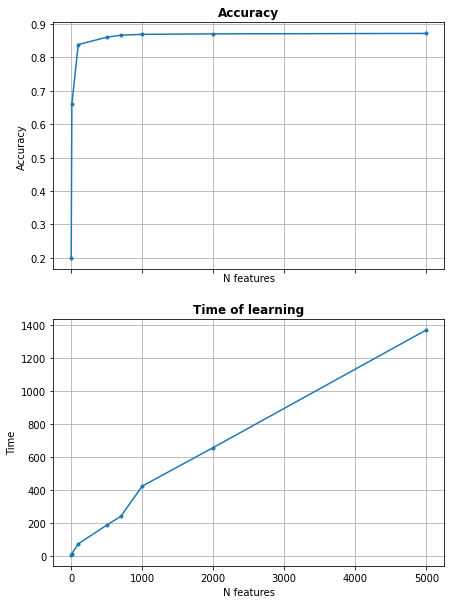

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7, 10))
ax1.set_title('Accuracy', weight='bold')
ax1.plot(n_features, ac_nfeat, marker='.')
ax1.grid()
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('N features')

ax2.set_title('Time of learning', weight='bold')
ax2.plot(n_features, time_nfeat, marker='.')
ax2.grid()
ax2.set_ylabel('Time')
ax2.set_xlabel('N features')
plt.show()

3. Кажется, что обе линейные модели над новыми признаками работают приблизительно одинаково: **logreg и svm** имеют сопоставимое качество, т.к. фактически оба алгоритма строят линейную разделяющую функцию над признаками в новом пространстве. Но можно сказать, что у логистической регрессии немного выше доля верных ответов и обучается она медленее.

In [ ]:
res_clf

,logreg,svm
Accuracy,0.871200,0.865700
Time,416.402739,254.555294


### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [24]:
class RFFPipelineFunction(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', sample_size=0.5,
                 hyper_params={}, kern_function=np.cos, add_bias_after=False, choose_hp_lgb=True):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: 'svm', 'logreg' or 'lgbm' classification model to use on top of pipeline.
        
        hyper_params, dict: classifier's hyperparameters.
        
        kern_function, callable function for matrices: function for generating new features (numpy functions).

        add_bias_after, bool: whether to add bias after applying kern_function (outside kern_function)
        or before applying function (inside kern_function).

        choose_hp_lgb, bool: whether to choose hyperparameters for LightGBM classifier.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.sample_size = sample_size
        self.classifier = classifier
        self.hyper_params = hyper_params
        self.kern_function = kern_function
        self.add_bias_after = add_bias_after
        self.choose_hp_lgb = choose_hp_lgb
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
            
        self.new_dim = X.shape[1]
        X_sample = X[np.random.randint(X.shape[0], size=int(np.ceil(X.shape[0] * self.sample_size))), :]
        self.sigma_sq = np.median(pdist(X_sample, metric='sqeuclidean'))
        
        self.w = np.zeros(shape=(self.n_features, self.new_dim))

        for n in range(self.n_features):
#             self.w[n, :] = multivariate_normal.rvs(cov=np.eye(self.new_dim) * (1/sigma_sq))
            self.w[n, :] = np.random.normal(loc=0, scale=1/np.sqrt(self.sigma_sq), size=self.new_dim)
        
        self.b = np.random.uniform(low=-np.pi, high=np.pi, size=self.n_features)
        
        if self.add_bias_after:
            fi = (self.kern_function(self.w @ X.T) + self.b.reshape(self.n_features, -1)).T
        else:
            fi = self.kern_function(self.w @ X.T + self.b.reshape(self.n_features, -1)).T
        
        if self.classifier=='logreg':
            self.clf = LogisticRegression(**self.hyper_params)
        elif self.classifier=='svm':
            self.clf = LinearSVC(**self.hyper_params)
        elif self.classifier=='lgbm':
            
            if self.choose_hp_lgb:
                hp_grid = {
                    'max_depth': np.arange(2, 10),
                    'n_estimators': [50, 100, 200, 300, 500],
                    'learning_rate': np.linspace(0.01, 10, 100)
                }

                gb = lgbm.LGBMClassifier(**self.hyper_params)
                skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
                rsearch = RandomizedSearchCV(gb, hp_grid, cv=skf, random_state=100)
                rsearch.fit(X_train, y_train)
                self.hyper_params = rsearch.best_params_
                self.hyper_params['objective'] = 'multiclass'

            self.clf = lgbm.LGBMClassifier(**self.hyper_params)

        self.clf.fit(fi, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
            
        if self.add_bias_after:
            fi_pred = (self.kern_function(self.w @ X.T) + self.b.reshape(self.n_features, -1)).T
        else:
            fi_pred = self.kern_function(self.w @ X.T + self.b.reshape(self.n_features, -1)).T
        
        pred = self.clf.predict_proba(fi_pred)
        
        return pred
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        if self.add_bias_after:
            fi_pred = (self.kern_function(self.w @ X.T) + self.b.reshape(self.n_features, -1)).T
        else:
            fi_pred = self.kern_function(self.w @ X.T + self.b.reshape(self.n_features, -1)).T
        pred = self.clf.predict(fi_pred)
        
        return pred

In [43]:
# Обучим с помощью градиентного бустинга и добавим к предыдущим результатам с логрегом и svm.

rff_lgb = RFFPipelineFunction(
    new_dim=new_dim, use_PCA=True, classifier='lgbm',
    hyper_params={'objective': 'multiclass'}, choose_hp_lgb=True
)

start = time.time()
rff_lgb.fit(x_train, y_train)
end = time.time()

pred_test = clf.predict(x_test)
ac_lgb = accuracy_score(y_test, pred_test)
time_lgb = end - start
res_clf['lgbm'] = [ac_lgb, time_lgb]

In [ ]:
res_clf

,logreg,svm,lgbm
Accuracy,0.871200,0.865700,0.868700
Time,416.402739,254.555294,3064.731196


С использованием градиентного бустинга в качестве классификатора над полученными случайными признаками Фурье качество модели практически не изменилось по сравнению с линейными классификаторами, но значительно увеличилось время обучения (также за счет подбора гиперпараметров). Получилось, что логистическая регрессия даже немного лучше разделила признаки, чем бустинг.

In [25]:
# В качестве других признаков используем синус, экспоненту и знак от полученных признаков.
# И также попробуем добавлять смещение не только внутри этих функций, но и после их применения.
functions = [np.cos, np.sin, np.exp, np.sign]
add_bias_after = [True, False]
diff_functions = [i for i in product(functions, add_bias_after)]

In [26]:
mask = np.random.randint(x_train.shape[0], size=int(np.ceil(x_train.shape[0] * 0.5)))
x_train_ = x_train[mask, :]
y_train_ = y_train[mask]

In [32]:
ac_func = []
time_func = []

for hp in tqdm(diff_functions):

    clf = RFFPipelineFunction(
        hyper_params={'max_iter': 500}, kern_function=hp[0], add_bias_after=hp[1]
    )

    start = time.time()
    clf.fit(x_train_, y_train_)
    end = time.time()

    pred_test = clf.predict(x_test)
    ac_func.append(accuracy_score(y_test, pred_test))
    time_func.append(end - start)

100%|██████████| 8/8 [26:35<00:00, 199.48s/it]


In [33]:
index_names = ['Accuracy', 'Time']
res_func = pd.DataFrame([ac_func, time_func], columns=diff_functions)
res_func.index = index_names
res_func

,"(<ufunc 'cos'>, True)","(<ufunc 'cos'>, False)","(<ufunc 'sin'>, True)","(<ufunc 'sin'>, False)","(<ufunc 'exp'>, True)","(<ufunc 'exp'>, False)","(<ufunc 'sign'>, True)","(<ufunc 'sign'>, False)"
Accuracy,0.861900,0.866700,0.851900,0.869100,0.861100,0.855500,0.812300,0.811700
Time,199.249507,198.575819,199.423517,197.306765,197.482533,201.127019,200.896813,197.962572


Эти же результаты ниже.

In [56]:
# Изначально добавляется смещение внутри функции

# Код для генерации названия колонок
add_bias_after_names = ['Bias outside', 'Bias inside']
function_names = []
for f in functions:
    srt_name = str(f).split(' ')[1][1:4]
    if srt_name == 'sig':
        function_names.append(str(f).split(' ')[1][1:5])
    else:
        function_names.append(srt_name)

col_names = [i for i in product(function_names, add_bias_after_names)]

index_names = ['Accuracy', 'Time']
res_func = pd.DataFrame([ac_func, time_func], columns=col_names)
res_func.index = index_names

In [58]:
res_func.T

,Accuracy,Time
"(cos, Bias outside)",0.8619,199.249507
"(cos, Bias inside)",0.8667,198.575819
"(sin, Bias outside)",0.8519,199.423517
"(sin, Bias inside)",0.8691,197.306765
"(exp, Bias outside)",0.8611,197.482533
"(exp, Bias inside)",0.8555,201.127019
"(sign, Bias outside)",0.8123,200.896813
"(sign, Bias inside)",0.8117,197.962572


Таким образом, видно, что добавление смещения внутри функции (**bias inside**)

$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$

или после применения функции (**bias outside**)

$$\tilde \varphi(x) = (
\cos (w_1^T x) + b_1,
\dots,
\cos (w_n^T x) + b_n
),$$

где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$

не сильно влияет на качество алгоритма.
В некоторых случаях (cos, sin) лучше добавлять смещение внутри функции, а в других случаях (exp, sign) лучше добавлять его после.

С разными типами функций качество незначительно меняется. У синуса доля верных ответов чуть выше по сравнению с косинусом.
У экспоненты и знака от признаков качество получилось ниже, чем у тригонометрических функций. Все алгоритмы обучались примерно одинаковое время.